# LSST CCOB ghost analysis

Develop the ghost images analysis

## TODO
- design a real image analysis to get a list of ghost spots
- compute distance between 2 ghost spots (distance + flux + size?)
- compute distance between 2 series of ghosts spots


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import batoid
import ghosts.plotter as plotter
import ghosts.simulator as simulator
import ghosts.tweak_optics as tweak_optics

from ghosts.analysis import compute_ghost_separations
from ghosts.analysis import find_nearest_ghost, match_ghosts, compute_reduced_distance
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_1, BEAM_CONFIG_2, FAST_BEAM_CONFIG_1



In [3]:
from ghosts.constants import *
print(f'LSST Camera has {LSST_CAMERA_PIXEL_DENSITY_MM2:.0f} pixels per mm^2')

LSST Camera has 36000 pixels per mm^2


In [4]:
# CCOB like geometry, i.e. lenses + filters
telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r.yaml")

In [5]:
# test list of optics
assert tweak_optics.get_list_of_optics(telescope)==['L1', 'L2', 'Filter', 'L3', 'Detector'], 'Not a CCOB optical setup'

# Make refractive interfaces partially reflective
# Call on current telescope
tweak_optics.make_optics_reflective(telescope)


0.02

Direct path is number 28
  central impact point is (0.099479, 0.000009)
  transmission is 0.8337

Maximum expected flux is 0.8337
Maximum bin content is 670.3379


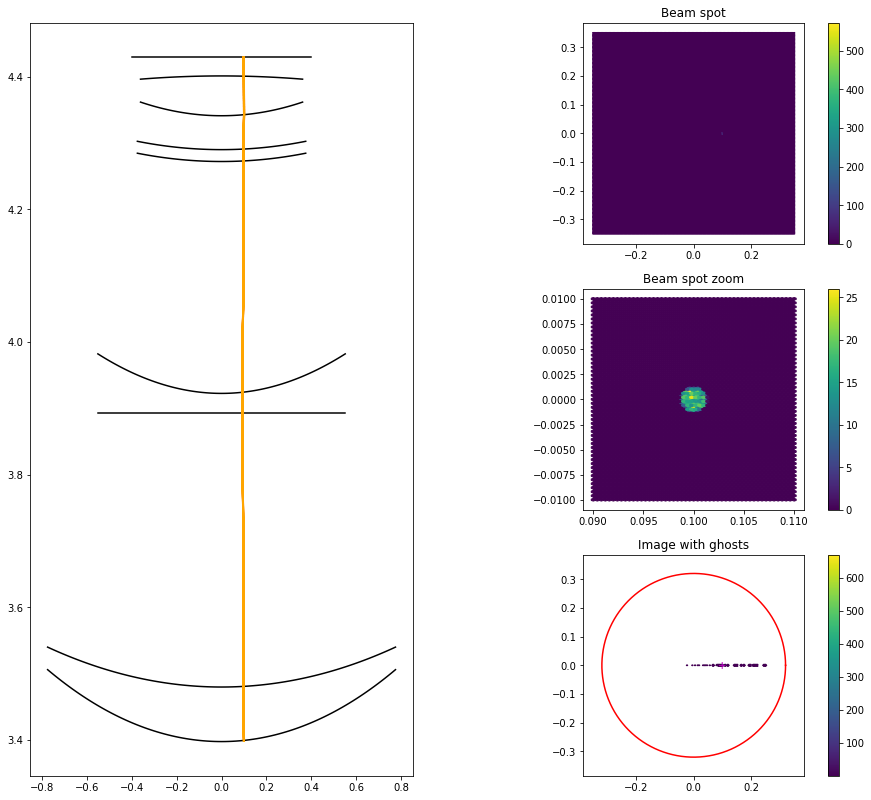

0

In [6]:
# Run simulation with standard beam config
traceFull, rForward, rReverse, rays = simulator.run_simulation(telescope, beam_config=BEAM_CONFIG_1)
simulation = [traceFull, rForward, rReverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)


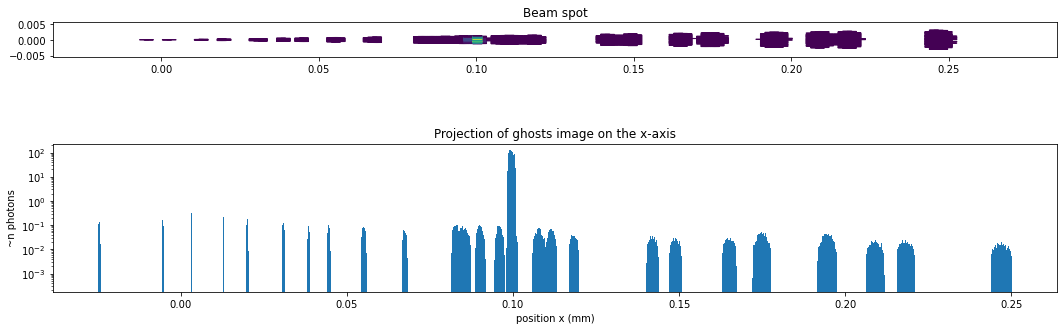

0

In [7]:
# Zoom on ghosts
plotter.plot_zoom_on_ghosts(rForward)

Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


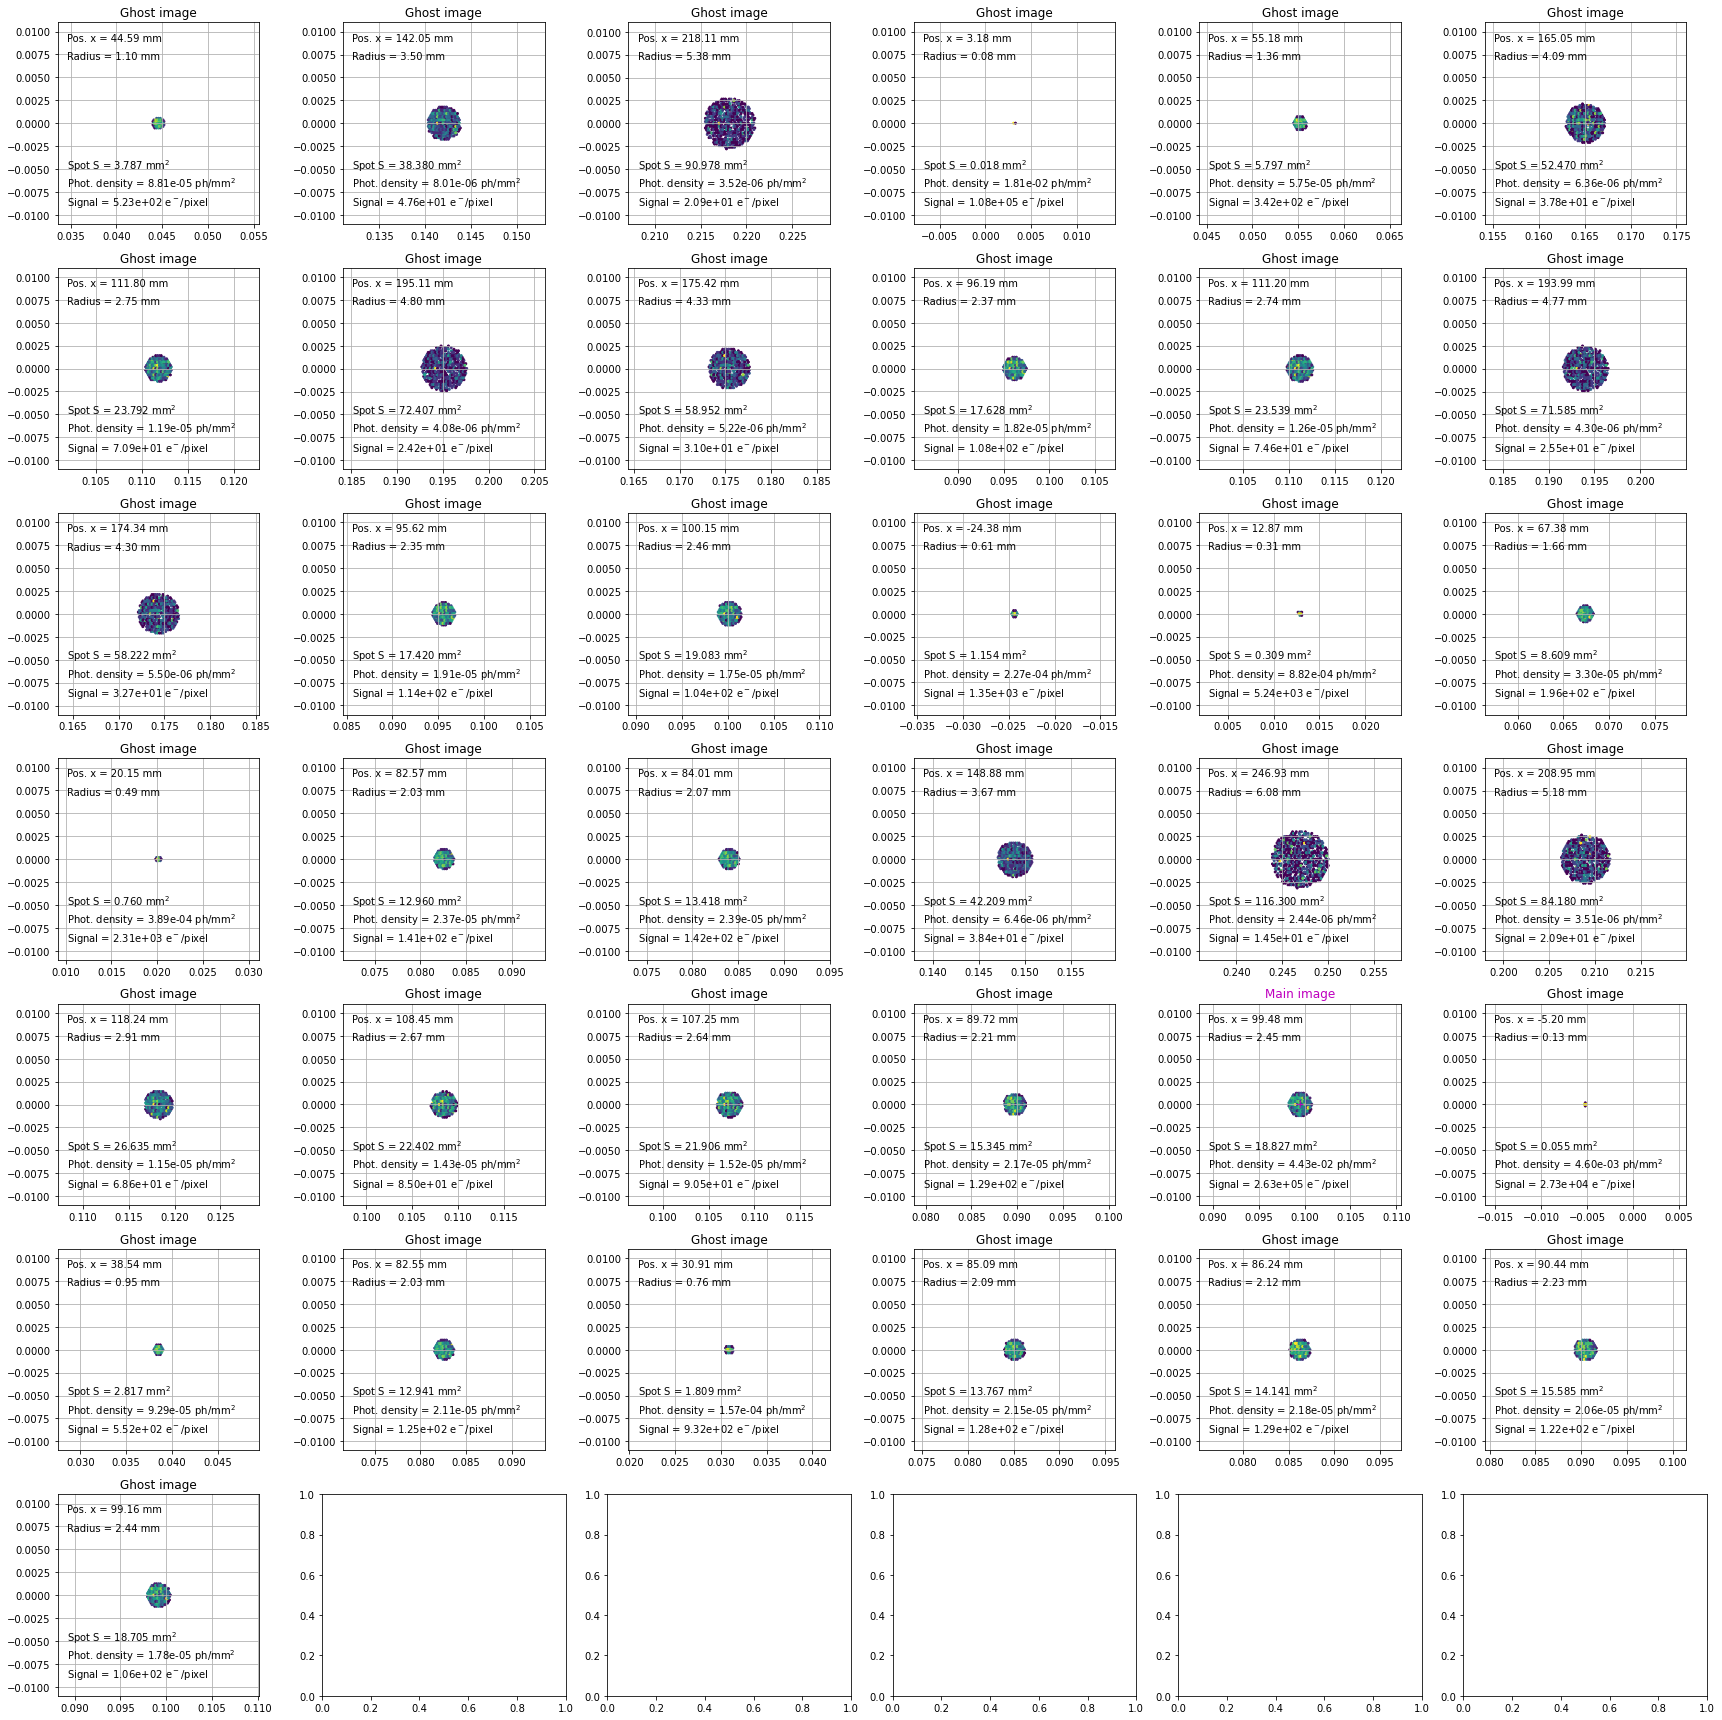

In [8]:
# make figure and fill with plots
plt.rcParams["figure.figsize"] = [24, 24]
spots_data = plotter.plot_ghosts_map(rForward)

In [9]:
data_frame_1 = make_data_frame(spots_data, BEAM_CONFIG_1)
data_frame_1.sort_values(by=['name'])

,config,n_photons,beam_x,beam_y,beam_width,beam_theta,beam_phi,index,name,pos_x,pos_y,width_x,width_y,radius,surface,pixel_signal
33,1,1000,0.1,0,0.00125,0.0,0.0,33,"(Detector, Filter_entrance)",0.085094,7.304500e-06,0.002087,0.002100,0.002093,13.767045,127.532271
34,1,1000,0.1,0,0.00125,0.0,0.0,34,"(Detector, Filter_exit)",0.086242,7.403009e-06,0.002115,0.002128,0.002122,14.141428,129.275255
29,1,1000,0.1,0,0.00125,0.0,0.0,29,"(Detector, L1_entrance)",-0.005197,-4.454609e-07,0.000135,0.000128,0.000132,0.054622,27346.609112
30,1,1000,0.1,0,0.00125,0.0,0.0,30,"(Detector, L1_exit)",0.038538,3.308291e-06,0.000943,0.000951,0.000947,2.816627,552.189202
31,1,1000,0.1,0,0.00125,0.0,0.0,31,"(Detector, L2_entrance)",0.082553,7.086511e-06,0.002022,0.002037,0.002030,12.941216,125.138241
32,1,1000,0.1,0,0.00125,0.0,0.0,32,"(Detector, L2_exit)",0.030906,2.653223e-06,0.000755,0.000763,0.000759,1.808567,932.348619
35,1,1000,0.1,0,0.00125,0.0,0.0,35,"(Detector, L3_entrance)",0.090443,7.763254e-06,0.002223,0.002232,0.002227,15.585057,122.137245
36,1,1000,0.1,0,0.00125,0.0,0.0,36,"(Detector, L3_exit)",0.099162,8.511949e-06,0.002433,0.002447,0.002440,18.704971,105.961310
10,1,1000,0.1,0,0.00125,0.0,0.0,10,"(Filter_entrance, L1_entrance)",0.111201,9.545233e-06,0.002730,0.002744,0.002737,23.538835,74.589185
11,1,1000,0.1,0,0.00125,0.0,0.0,11,"(Filter_entrance, L1_exit)",0.193994,1.665223e-05,0.004760,0.004787,0.004773,71.584505,25.538162


Rotation around Y as Euler:
 [0. 1. 0.]
Rotation around Y as  matrix:
 [[ 0.9998477   0.          0.01745241]
 [ 0.          1.          0.        ]
 [-0.01745241  0.          0.9998477 ]]
L1 before rotation:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
L1 after rotation:
 [[ 0.9998477   0.          0.01745241]
 [ 0.          1.          0.        ]
 [-0.01745241  0.          0.9998477 ]]
Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


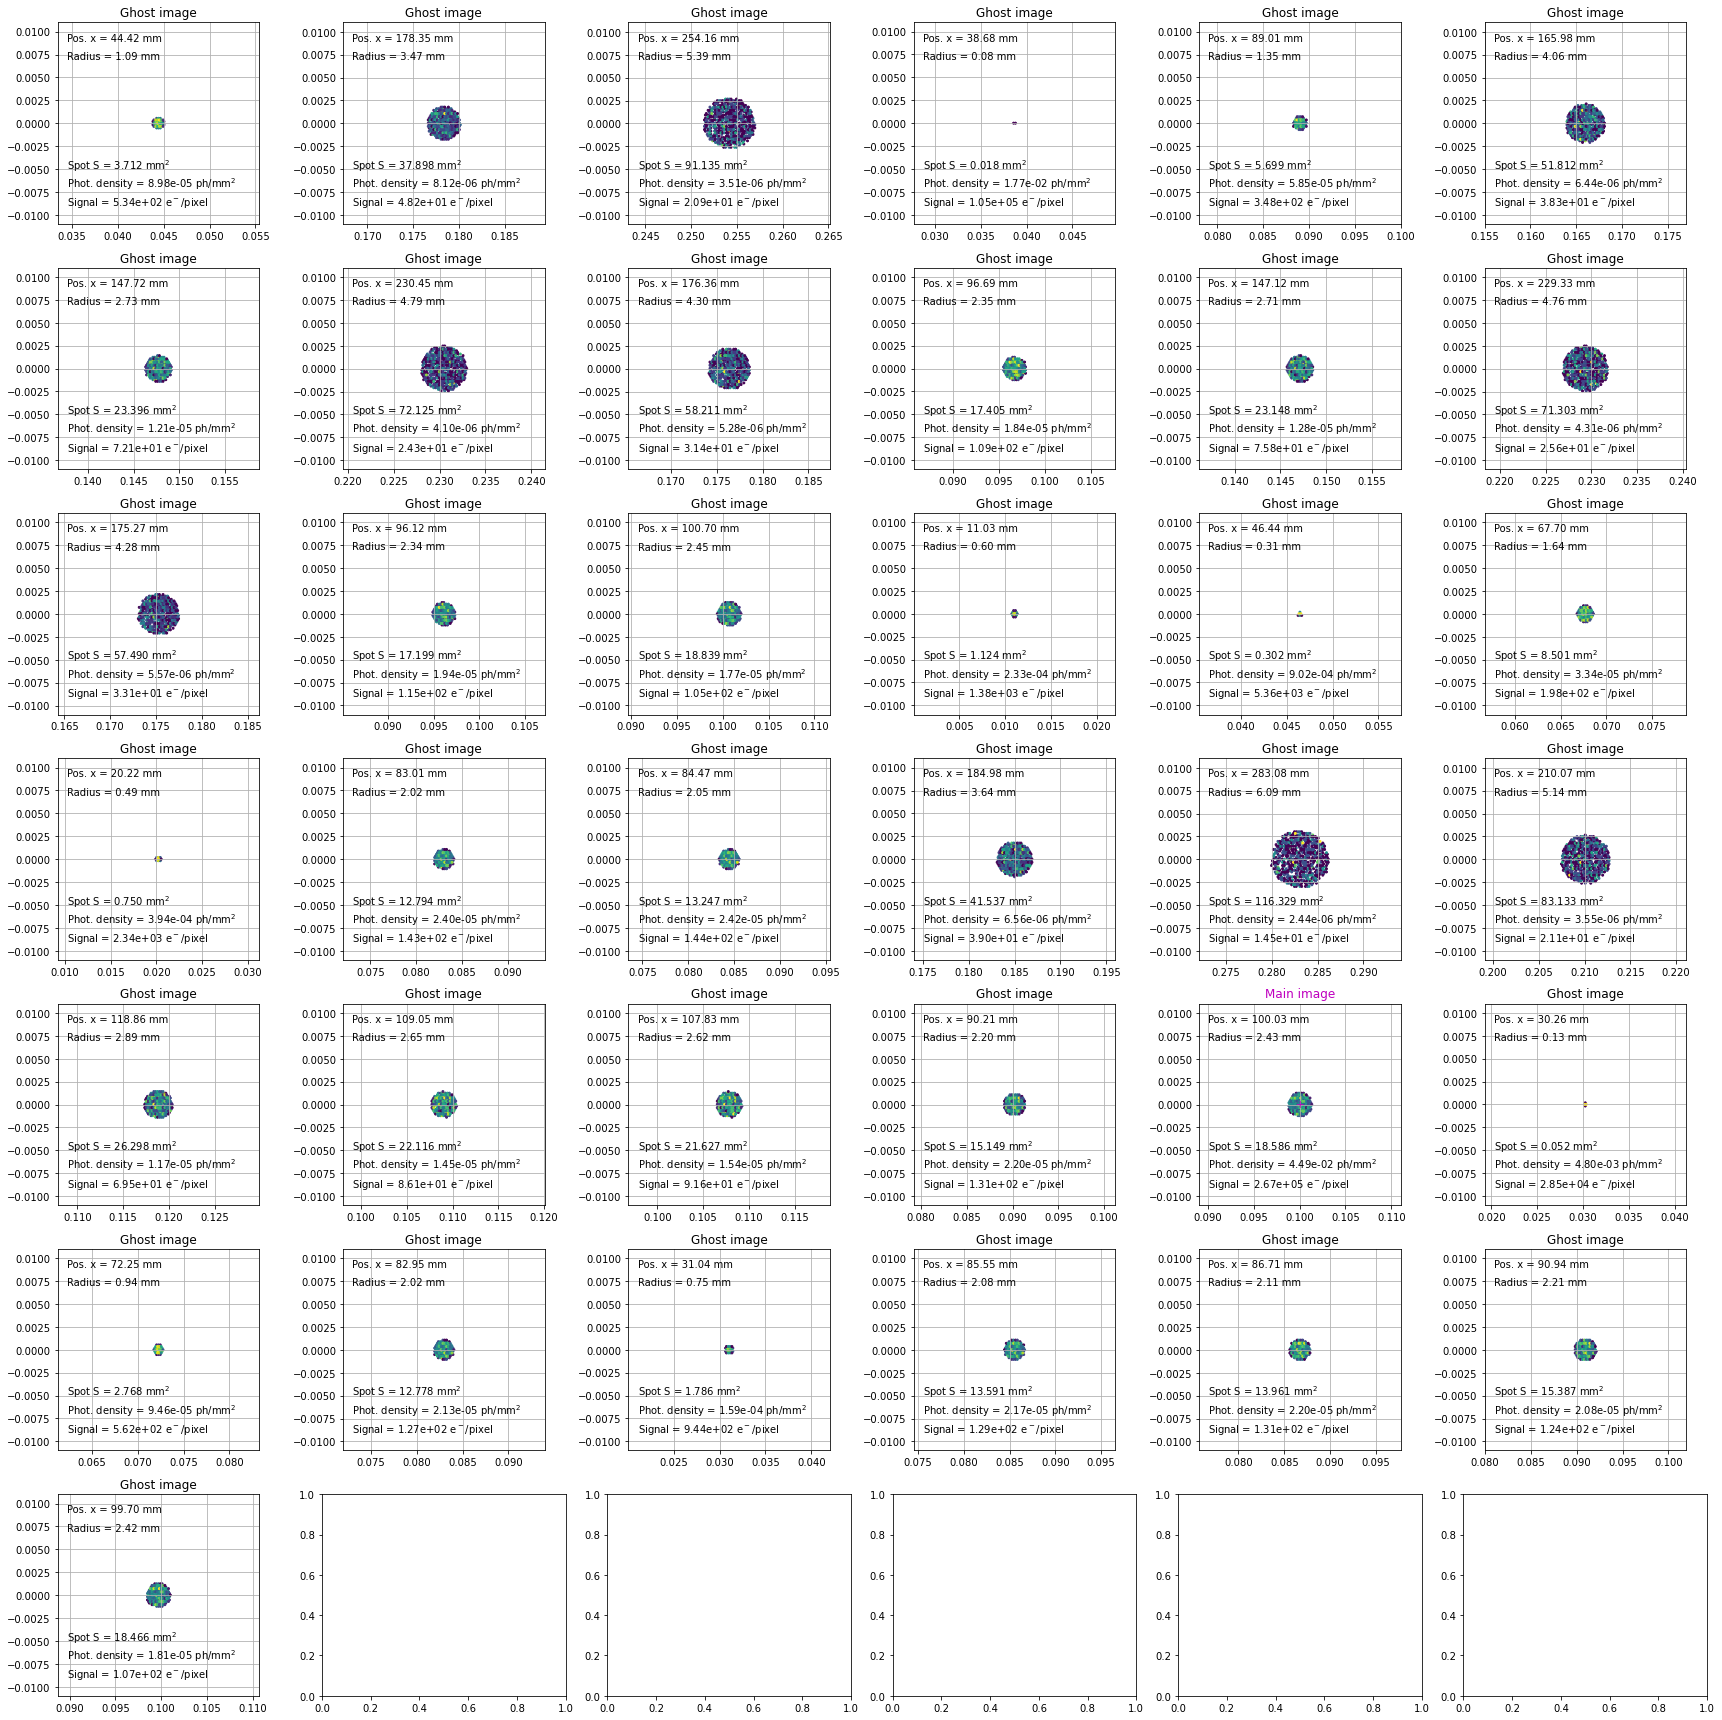

In [10]:
# Run another simulation with rotated L1
rotated_telescope = tweak_optics.rotate_optic(telescope, 'L1', axis='y', angle=1, verbose=True)
tweak_optics.make_optics_reflective(rotated_telescope)

traceFull_2, rForward_2, rReverse_2, rays_2 = simulator.run_simulation(rotated_telescope,
                                                                       beam_config=BEAM_CONFIG_1)
plt.rcParams["figure.figsize"] = [24, 24]
spots_data_2 = plotter.plot_ghosts_map(rForward_2)


In [11]:
data_frame_2 = make_data_frame(spots_data_2, BEAM_CONFIG_1)
data_frame_2.sort_values(by=['name'])

,config,n_photons,beam_x,beam_y,beam_width,beam_theta,beam_phi,index,name,pos_x,pos_y,width_x,width_y,radius,surface,pixel_signal
33,1,1000,0.1,0,0.00125,0.0,0.0,33,"(Detector, Filter_entrance)",0.085551,1.042845e-05,0.002074,0.002086,0.002080,13.591442,129.180000
34,1,1000,0.1,0,0.00125,0.0,0.0,34,"(Detector, Filter_exit)",0.086706,1.056909e-05,0.002102,0.002114,0.002108,13.960998,130.945992
29,1,1000,0.1,0,0.00125,0.0,0.0,29,"(Detector, L1_entrance)",0.030259,-6.339946e-07,0.000131,0.000127,0.000129,0.052361,28527.094387
30,1,1000,0.1,0,0.00125,0.0,0.0,30,"(Detector, L1_exit)",0.072249,4.714875e-06,0.000934,0.000943,0.000939,2.767684,561.954089
31,1,1000,0.1,0,0.00125,0.0,0.0,31,"(Detector, L2_entrance)",0.082954,1.011739e-05,0.002010,0.002023,0.002017,12.778135,126.735313
32,1,1000,0.1,0,0.00125,0.0,0.0,32,"(Detector, L2_exit)",0.031040,3.787876e-06,0.000750,0.000758,0.000754,1.785981,944.139178
35,1,1000,0.1,0,0.00125,0.0,0.0,35,"(Detector, L3_entrance)",0.090936,1.108397e-05,0.002210,0.002217,0.002213,15.386597,123.712605
36,1,1000,0.1,0,0.00125,0.0,0.0,36,"(Detector, L3_exit)",0.099705,1.215235e-05,0.002419,0.002430,0.002424,18.465886,107.333234
10,1,1000,0.1,0,0.00125,0.0,0.0,10,"(Filter_entrance, L1_entrance)",0.147123,1.361904e-05,0.002705,0.002724,0.002714,23.148055,75.848383
11,1,1000,0.1,0,0.00125,0.0,0.0,11,"(Filter_entrance, L1_exit)",0.229327,2.384316e-05,0.004760,0.004768,0.004764,71.303357,25.638859


In [12]:
match = match_ghosts(data_frame_1, data_frame_2)
match

,ghost_1,ghost_2,distance
0,0,0,0.000174
1,1,10,0.005074
2,2,23,0.008047
3,3,15,0.007851
4,4,16,0.008739
5,5,5,0.000933
6,6,25,0.002751
7,7,21,0.010122
8,8,12,0.000153
9,9,13,0.000069


In [13]:
compute_reduced_distance(match)

0.0012099955666511732

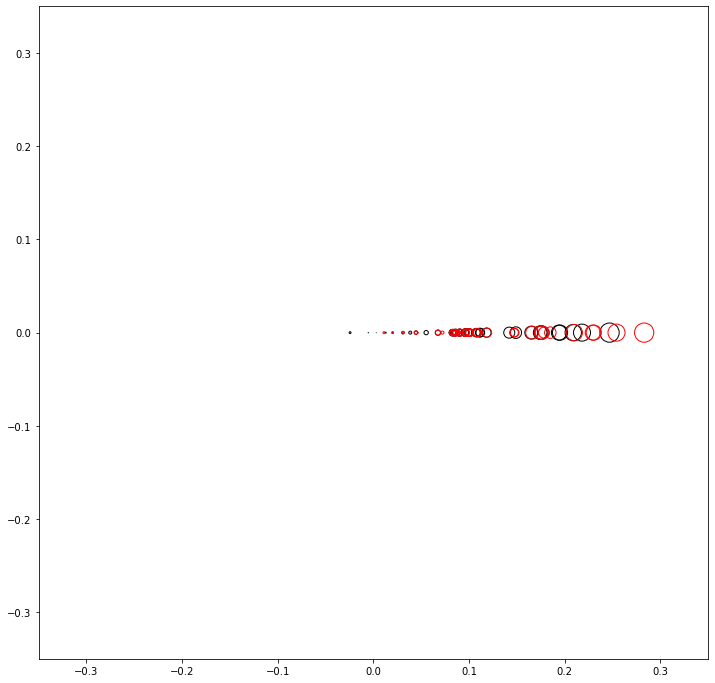

In [14]:
fig, ax = plotter.plot_spots([data_frame_1, data_frame_2])

In [15]:
# See what happens with a random telescope
data_frame_r, ghost_separations_r = simulator.full_random_telescope_sim(telescope,\
                                    max_angle=1, max_shift=0.001, beam_config=BEAM_CONFIG_1)


distance = 0.00121


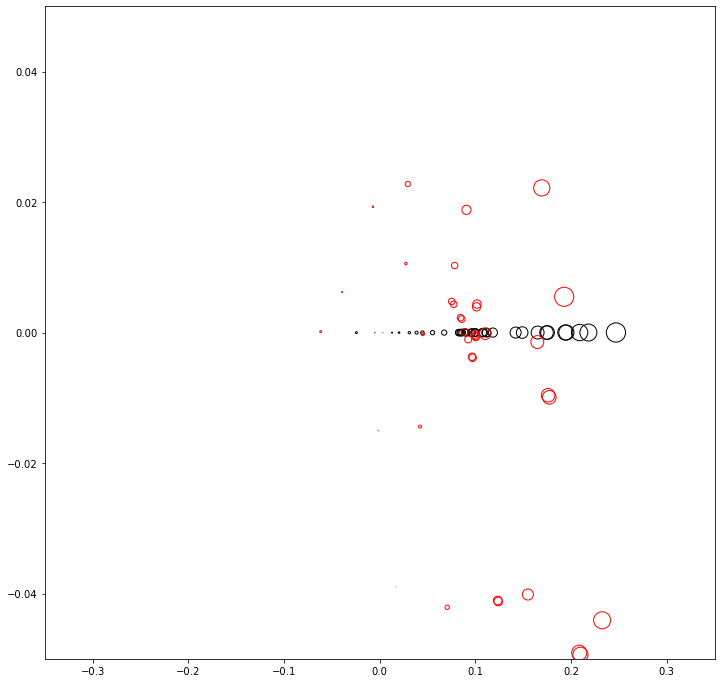

In [16]:
match_r = match_ghosts(data_frame_1, data_frame_r)
dist_r = compute_reduced_distance(match)
print(f'distance = {dist_r:.5f}')
fig, ax = plotter.plot_spots([data_frame_1, data_frame_r], range_y=(-0.05, 0.05))


In [17]:
distances = list()
for i in range(10):
    df_i, gs_i = simulator.full_random_telescope_sim(telescope,\
                         max_angle=1, max_shift=0.001, beam_config=FAST_BEAM_CONFIG_1)
    match_i = match_ghosts(data_frame_1, df_i)
    dist_i = compute_reduced_distance(match_i)
    distances.append(dist_i)
    print(f'distance {i} = {dist_i:.6f}')


distance 0 = 0.002107
distance 1 = 0.002038
distance 2 = 0.003154
distance 3 = 0.002418
distance 4 = 0.001956
distance 5 = 0.002832
distance 6 = 0.002040
distance 7 = 0.001603
distance 8 = 0.002042
distance 9 = 0.002572


(array([1., 0., 4., 1., 0., 1., 1., 1., 0., 1.]),
 array([0.00160289, 0.001758  , 0.00191311, 0.00206822, 0.00222334,
        0.00237845, 0.00253356, 0.00268868, 0.00284379, 0.0029989 ,
        0.00315402]),
 <BarContainer object of 10 artists>)

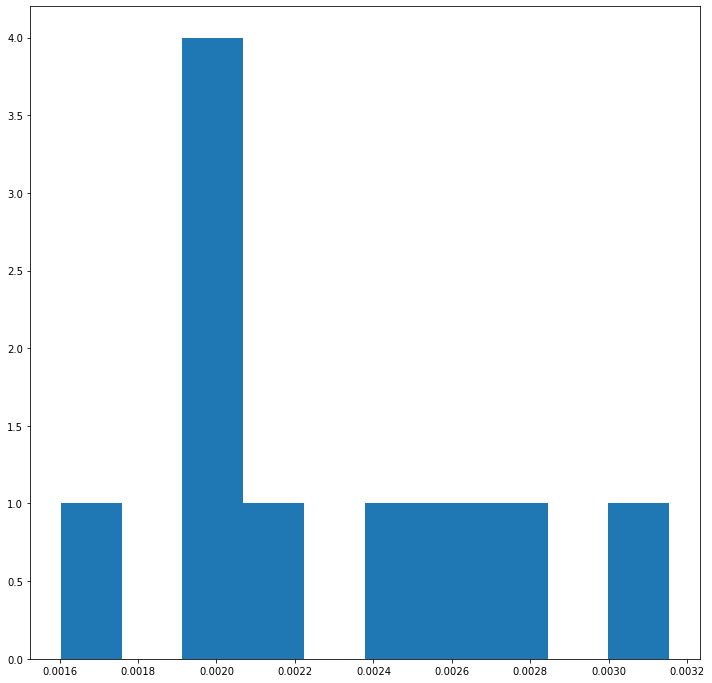

In [18]:
plt.hist(distances)
# plt.xlim(0., 0.010)